In [40]:
import numpy as np
import os
from scipy import io 
import pandas as pd 
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
from scipy.spatial import KDTree 
from matplotlib import cm as CM
from PIL import Image
import torch
from pathlib import Path
from skimage.draw import disk 
#from GT_functions import *

In [17]:
#Definimos la ruta del dataset
root = r'C:\Users\Usuario\Pictures\Bases de Datos\Shanghai Tech'

#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')

#path_sets = [part_A_train,part_A_test]


img_paths = []
for path in Path(part_A_train).glob('*.jpg'):
    img_paths.append(path)


In [54]:
def gaussian_filter_density(gts):
    density = np.zeros(gts.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gts)
    if gt_count == 0:
        return density

    
    leafsize = 2048
    gts_points =  np.transpose(gts.nonzero())
    tree = KDTree(gts_points, leafsize= leafsize)

    result = pd.DataFrame({'x_point': [], 'y_point': [], 'distance': []})
    
    for pt in gts_points:
        pt2d = np.zeros(gts.shape, dtype=np.float32)
        try:
            pt2d[pt[0], pt[1]] = 1
        except:
            print(pt)

        distances, locations = tree.query(pt, k=5)
        if gt_count > 1:
           sigma = (distances[2]+distances[3]+distances[4])*0.3
           #sigma = 1
        else:
           sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point

        density += gaussian_filter(pt2d, sigma, mode='constant')

        # result.loc[i, 'x_point'] = pt[0]
        # result.loc[i, 'y_point'] = pt[1]
        # result.loc[i, 'distance'] = sigma
        # i = i + 1

    
    #plt.imsave(str(i) + '.jpg', density)
    return density



In [55]:
for img_path in img_paths[0:1]:

    i = 0 
    mat = io.loadmat(str(img_path).replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img = plt.imread(img_path)

    #aqui solo tomamos el alto y el ancho de la imagen
    k = np.zeros((img.shape[0],img.shape[1]))

    #Hacemos esto porque la wea de .mat se guarda raro
    gt = mat["image_info"][0,0][0,0][0]
    
    #Validamos que esten dentro de nuestra matriz, y colocamos un uno donde encontramos una cabeza
    for i in range(0,len(gt)):
        if (int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]):
            #rr, cc = disk((gt[i][1], gt[i][0]), 10, shape=k.shape)
            k[int(gt[i][1]), int(gt[i][0])] = 1


    fg = gaussian_filter_density(k)

    #plt.imsave('mapa de puntos.jpg', k, cmap='gray')
    plt.imsave('proof.jpg', fg)
    
    i = i + 1
    
    #with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
     #       hf['density'] = k

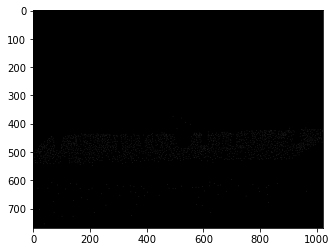

In [49]:
plt.imshow(k, cmap = 'gray')